# Onset Time Calculation
Going to investigate the automation of start and end times of the onset phase. For simplicity we will use the manual background timings from Hugh's paper and incorporate our automatic ones afterwards in order to see the difference in results.

We will start with the 2011-08-09 X-class flare as it has one of the clearset onset phases.

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import re

from scipy.io import readsav
from scipy import stats

from astropy.time import Time
from astropy.time import TimeDelta

from sunpy import timeseries as ts
from sunpy.net import attrs as a
from sunpy.net import Fido
from sunpy.time import parse_time, find_time

import pandas as pd

import goesxrs_temp as gtem #from Ian's functions

from Onsets_temp import *

# Just setup plot fonts
plt.rcParams.update({'font.size': 18,'font.family':"sans-serif",\
                         'font.sans-serif':"Arial",'mathtext.default':"regular", 'axes.linewidth' : 2})

c:\Users\William\Documents\University\MastersProj\hot_onset\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Background-subtracted flare 2014-02-14

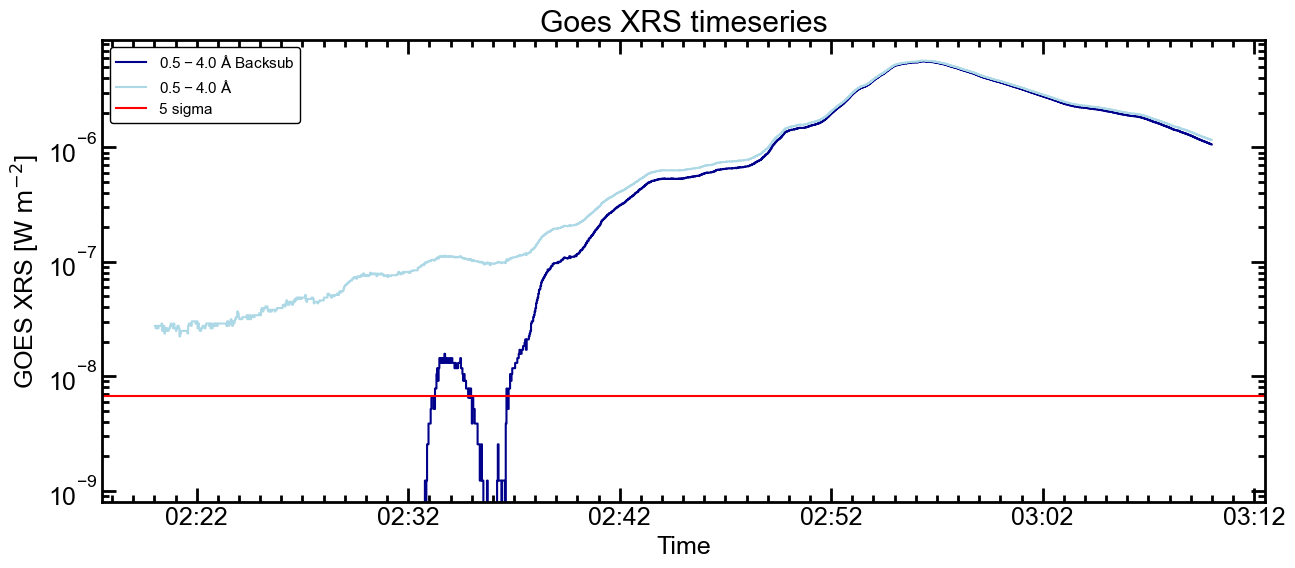

In [3]:
data = r"C:\Users\William\Documents\University\MastersProj\Data\Test\GOES15_2s\sci_gxrs-l2-irrad_g15_d20140214_v0-0-0.nc"
g15 = ts.TimeSeries(data, concatenate=True)
trange = a.Time("2014-02-14 02:20:00", "2014-02-14 03:10:00")
trunc_g15=g15.truncate(trange.start.iso,trange.end.iso)
g_tims = trunc_g15.index
g_short = trunc_g15.quantity("xrsa").value
g_long = trunc_g15.quantity("xrsb").value

#bcktrange = a.Time("2014-02-14 02:27:01","2014-02-14 02:28:43") #Hugh's timings
bcktrange = a.Time("2014-02-14 02:35:36", "2014-02-14 02:36:36") #My timings 
bcktrunc_g15=g15.truncate(bcktrange.start.iso,bcktrange.end.iso)
bckg_tims = bcktrunc_g15.index

bckg_short = np.mean(bcktrunc_g15.quantity("xrsa").value)
bckg_short_std = np.std(bcktrunc_g15.quantity("xrsa").value)
bckg_long = np.mean(bcktrunc_g15.quantity("xrsb").value)

g_short_sub = g_short - bckg_short
g_long_sub = g_long - bckg_long



fig,ax = plt.subplots(figsize=(15, 6))
plt.title("Goes XRS timeseries")
plt.plot(g_tims, g_short_sub, drawstyle='steps-post', color = 'darkblue', label = r"$0.5-4.0\;\AA$ Backsub")
plt.plot(g_tims, g_short, drawstyle='steps-post', color = 'lightblue', label = r"$0.5-4.0\;\AA$")
plt.axhline(5*bckg_short_std, label = "5 sigma", color = 'r')
ax.set_ylabel("GOES XRS [$\mathrm{W\;m^{-2}}$] ")
ax.set_xlabel("Time")
ax.set_yscale("log")
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=1)
ax.xaxis.set_major_locator(majorx)
ax.xaxis.set_minor_locator(minorx)
ax.xaxis.set_major_formatter(myFmt)
plt.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
plt.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
plt.tick_params(which='major', size=10, width=2, direction='in', right='on')
plt.tick_params(which='minor', size=5, width=2, direction='in', right='on')
plt.legend(fancybox = True, fontsize = 11, framealpha = 1, edgecolor = 'black')
plt.show()

#### Start Time of Onset: 5 sigma rule

We will use the '5-sigma' rule to identify the start of the onset phase here. Want to find the first point after the background sub period that is above 5 standard deviations of the variance of the background sub period.

In [4]:
#Start by truncating short channel data from end of background interval (or start time) to peak time.
#trange_search = a.Time("2014-02-14 02:30:00", "2014-02-14 02:57:00")
trange_search = a.Time("2014-02-14 02:36:36", "2014-02-14 02:57:00")
trunc_srch = g15.truncate(trange_search.start.iso,trange_search.end.iso)
g_tims_srch = trunc_srch.index
g_short_srch = trunc_srch.quantity("xrsa").value
g_short_srch = g_short_srch - bckg_short
g_long_srch = trunc_srch.quantity("xrsb").value
g_long_srch = g_short_srch - bckg_short

#Find first point above 5-sigma
onset_start = g_tims_srch[(next(i for i, v in enumerate(g_short_srch) if v >= 5*bckg_short_std))]

### End time of onset: Cumulative Variance approach

We will first look at the cumulative variance of the flux, and then the temperature.

c:\Users\William\Documents\University\MastersProj\hot_onset\lib\site-packages\numpy\core\fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\William\Documents\University\MastersProj\hot_onset\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\William\Documents\University\MastersProj\hot_onset\lib\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


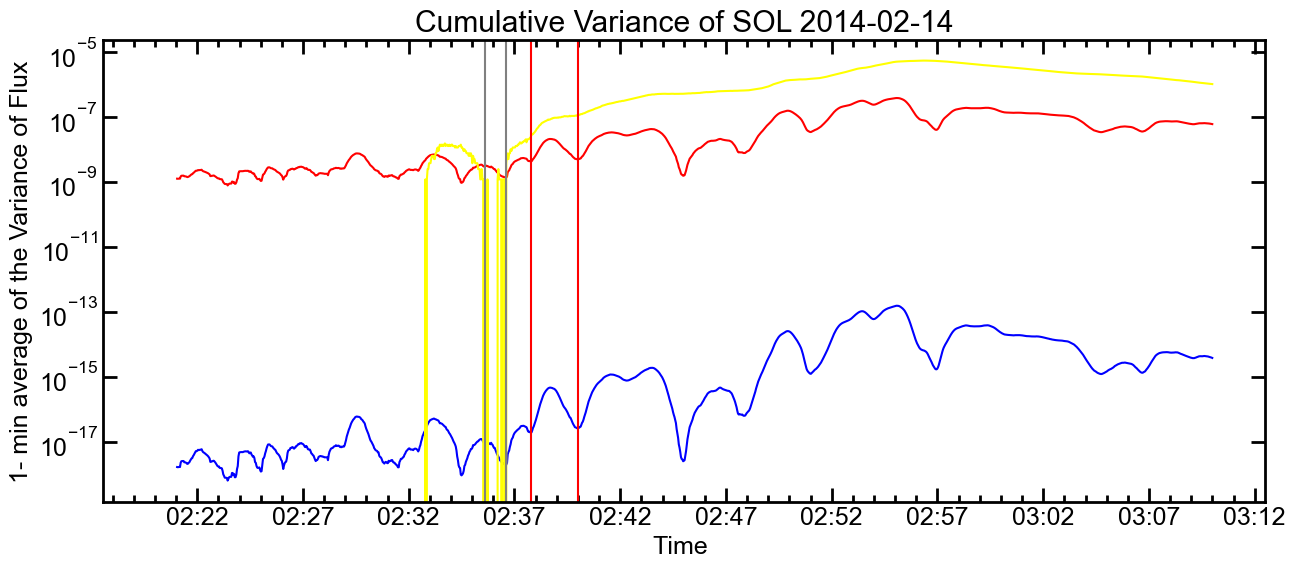

In [15]:
#Calculating the cumulative variance at each point
vars = []
for i in range(0,len(g_short_sub)):
    var = np.var(g_short_sub[i-30:i])
    vars.append(var)

#Calculating the turning point through 'find peaks'
from scipy.signal import find_peaks
from datetime import datetime

fig,ax = plt.subplots(figsize=(15, 6))
plt.title('Cumulative Variance of SOL 2014-02-14')
plt.plot(g_tims, np.sqrt(vars), color = 'red', label = 'std')
plt.plot(g_tims, vars, color = 'blue', label = 'Variance')
plt.plot(g_tims, g_short_sub, color = 'yellow', label = 'Flux')
ax.axvline(datetime.strptime("02/14/14 02:37:47", '%m/%d/%y %H:%M:%S'), color = 'r')
ax.axvline(datetime.strptime("02/14/14 02:39:59", '%m/%d/%y %H:%M:%S'), color = 'r')
ax.axvline(datetime.strptime("02/14/14 02:35:36", '%m/%d/%y %H:%M:%S'), color = 'gray')
ax.axvline(datetime.strptime("02/14/14 02:36:36", '%m/%d/%y %H:%M:%S'), color = 'gray')
ax.set_ylabel("1- min average of the Variance of Flux")
ax.set_xlabel("Time ")
ax.set_yscale("log")
#ax.set_ylim(10**(-18),10**(-10))
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=5)
minorx= matplotlib.dates.MinuteLocator(interval=1)
ax.xaxis.set_major_locator(majorx)
ax.xaxis.set_minor_locator(minorx)
ax.xaxis.set_major_formatter(myFmt)
plt.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
plt.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
plt.tick_params(which='major', size=10, width=2, direction='in', right='on')
plt.tick_params(which='minor', size=5, width=2, direction='in', right='on')
plt.show()

### Cumulative Variance of the Temperature
Going to plot the time varying temp from the end of the background interval to the peak time. Then look at the variance of the temp (as above with the flux).
 [Currently not working]

[  1.0001   1.0001   1.0001   1.0001   1.0001   1.0001   1.0001   1.0001
   1.0001   1.0001   1.0001   1.0001   1.0001   1.0001   1.0001   1.0001
   1.0001   1.0001   1.0001   1.0001   1.0001   1.0001   1.0001   1.0001
   1.0001   1.0001   1.0001   1.0001   1.0001   1.0001   1.0001   1.0001
   1.0001   1.0001   1.0001   1.0001   1.0001   1.0001   1.0001   1.0001
   1.0001   1.0001   1.0001   1.0001   1.0001   1.0001   1.0001   1.0001
   1.0001   1.0001   1.0001   1.0001   1.0001   1.0001   1.0001   1.0001
   1.0001   1.0001   1.0001   1.0001   1.0001   1.0001   1.0001   1.0001
   1.0001   1.0001   1.0001   1.0001   1.0001   1.0001   1.0001 100.
   1.0001 100.     100.     100.     100.     100.     100.     100.
 100.     100.     100.     100.     100.     100.     100.     100.
 100.     100.     100.     100.     100.     100.     100.     100.
 100.     100.     100.     100.     100.     100.     100.     100.
 100.     100.     100.     100.     100.     100.     100.     100.
 1

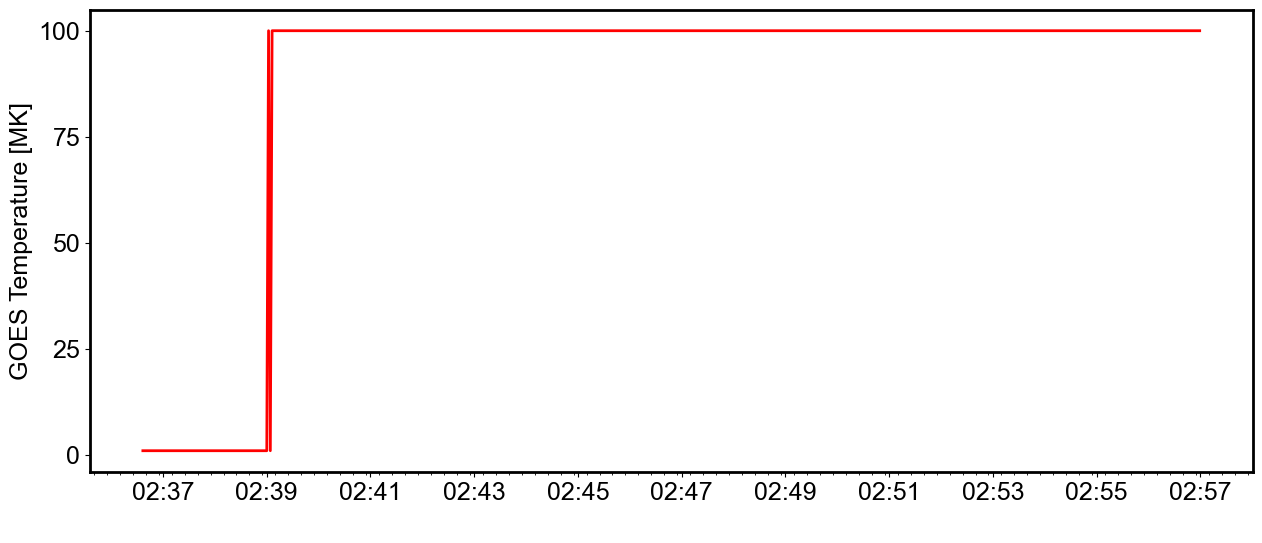

In [6]:
# Fetching Temperature and Emission Measures
tmk_srch, em_srch = gtem.get_tem(g_long_srch, g_short_srch)

print(tmk_srch)

fig,ax1 = plt.subplots(figsize=(15, 6))
plt.plot(g_tims_srch, tmk_srch, marker=None, color='red',lw=2)
ax1.set_ylabel("GOES Temperature [MK]")
ax1.set_xlabel(" ")
#ax1.set_ylim([0,20])
ax1.yaxis.set_major_locator(plt.MaxNLocator(5))
#ax1.set_xlim([trange_onset.start.datetime,trange_onset.end.datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=2)
minorx= matplotlib.dates.SecondLocator(interval=15)
ax1.xaxis.set_major_locator(majorx)
ax1.xaxis.set_minor_locator(minorx)
ax1.xaxis.set_major_formatter(myFmt)
plt.show()

### Looking at the derivative of the variance

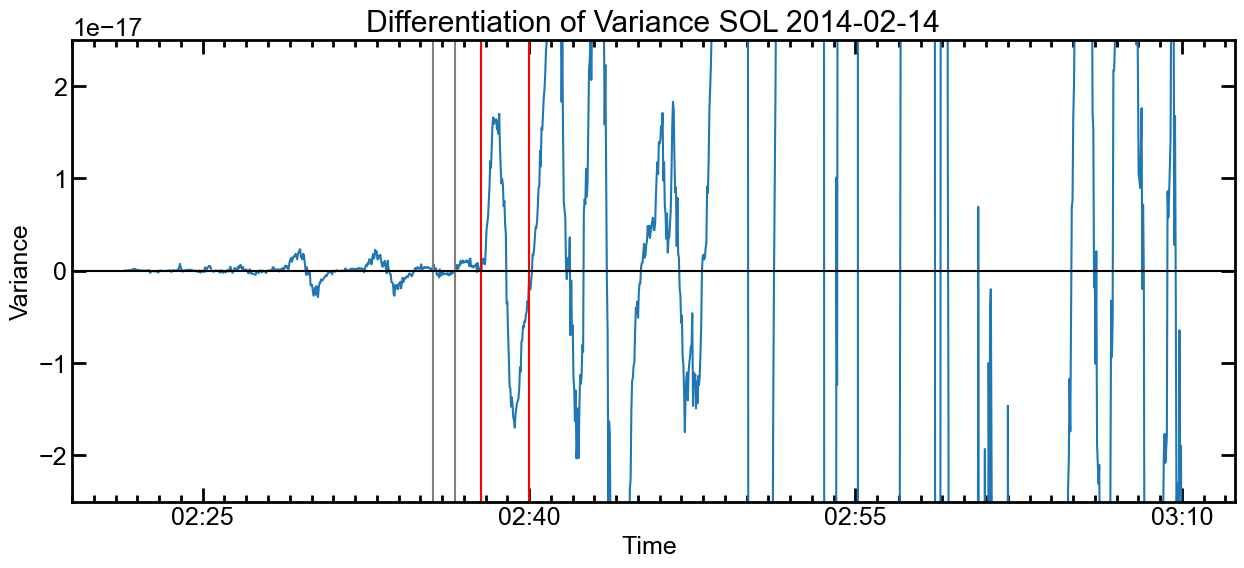

In [7]:
tmp=pd.Series(vars, g_tims)
tmp.index=pd.to_datetime(tmp.index)

df=pd.DataFrame(tmp)
df['secvalue']=df.index.astype(np.int64)/1e+9
df['slope']= tmp.diff()/df['secvalue'].diff()

fig,ax = plt.subplots(figsize=(15, 6))
plt.title('Differentiation of Variance SOL 2014-02-14')
plt.plot(df.index, df['slope'].values, label = 'slope')
ax.axvline(datetime.strptime("02/14/14 02:35:36", '%m/%d/%y %H:%M:%S'), color = 'gray')
ax.axvline(datetime.strptime("02/14/14 02:36:36", '%m/%d/%y %H:%M:%S'), color = 'gray')
ax.axvline(datetime.strptime("02/14/14 02:37:47", '%m/%d/%y %H:%M:%S'), color = 'r')
ax.axvline(datetime.strptime("02/14/14 02:39:59", '%m/%d/%y %H:%M:%S'), color = 'r')
ax.axhline(0, color = 'black')
ax.set_ylabel("Variance")
ax.set_xlabel("Time ")
ax.set_ylim(-0.25e-16,0.25e-16)
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=15)
minorx= matplotlib.dates.MinuteLocator(interval=1)
ax.xaxis.set_major_locator(majorx)
ax.xaxis.set_minor_locator(minorx)
ax.xaxis.set_major_formatter(myFmt)
plt.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
plt.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
plt.tick_params(which='major', size=10, width=2, direction='in', right='on')
plt.tick_params(which='minor', size=5, width=2, direction='in', right='on')
plt.show()

### Looking at TEM of Onset

Onset Start: "2014-02-14 02:36:36"
Onset End: 2014-02-14 02:40:30

In [8]:
trange_onset = a.Time("2014-02-14 02:36:36", "2014-02-14 02:39:52")
#trange_onset = a.Time("2014-02-14 02:30:30", "2014-02-14 03:00:30")
trunc_onset = g15.truncate(trange_onset.start.iso,trange_onset.end.iso)
g_onset_tims = trunc_onset.index
g_onset_short = trunc_onset.quantity("xrsa").value - bckg_short
g_onset_long = trunc_onset.quantity("xrsb").value - bckg_long

# Fetching Temperature and Emission Measures
tmk, em = gtem.get_tem(g_onset_long, g_onset_short)

#calculating mean T, EM for backsubbed new data.
tmk_mnho=np.mean(tmk)
em_mnho=np.mean(em)
print("")
print('Mean T during onset: {0:.2f} MK'.format(tmk_mnho))
print('Mean EM during onset: {0:.2e} cm^-3'.format(em_mnho))


Mean T during onset: 11.77 MK
Mean EM during onset: 2.12e+47 cm^-3


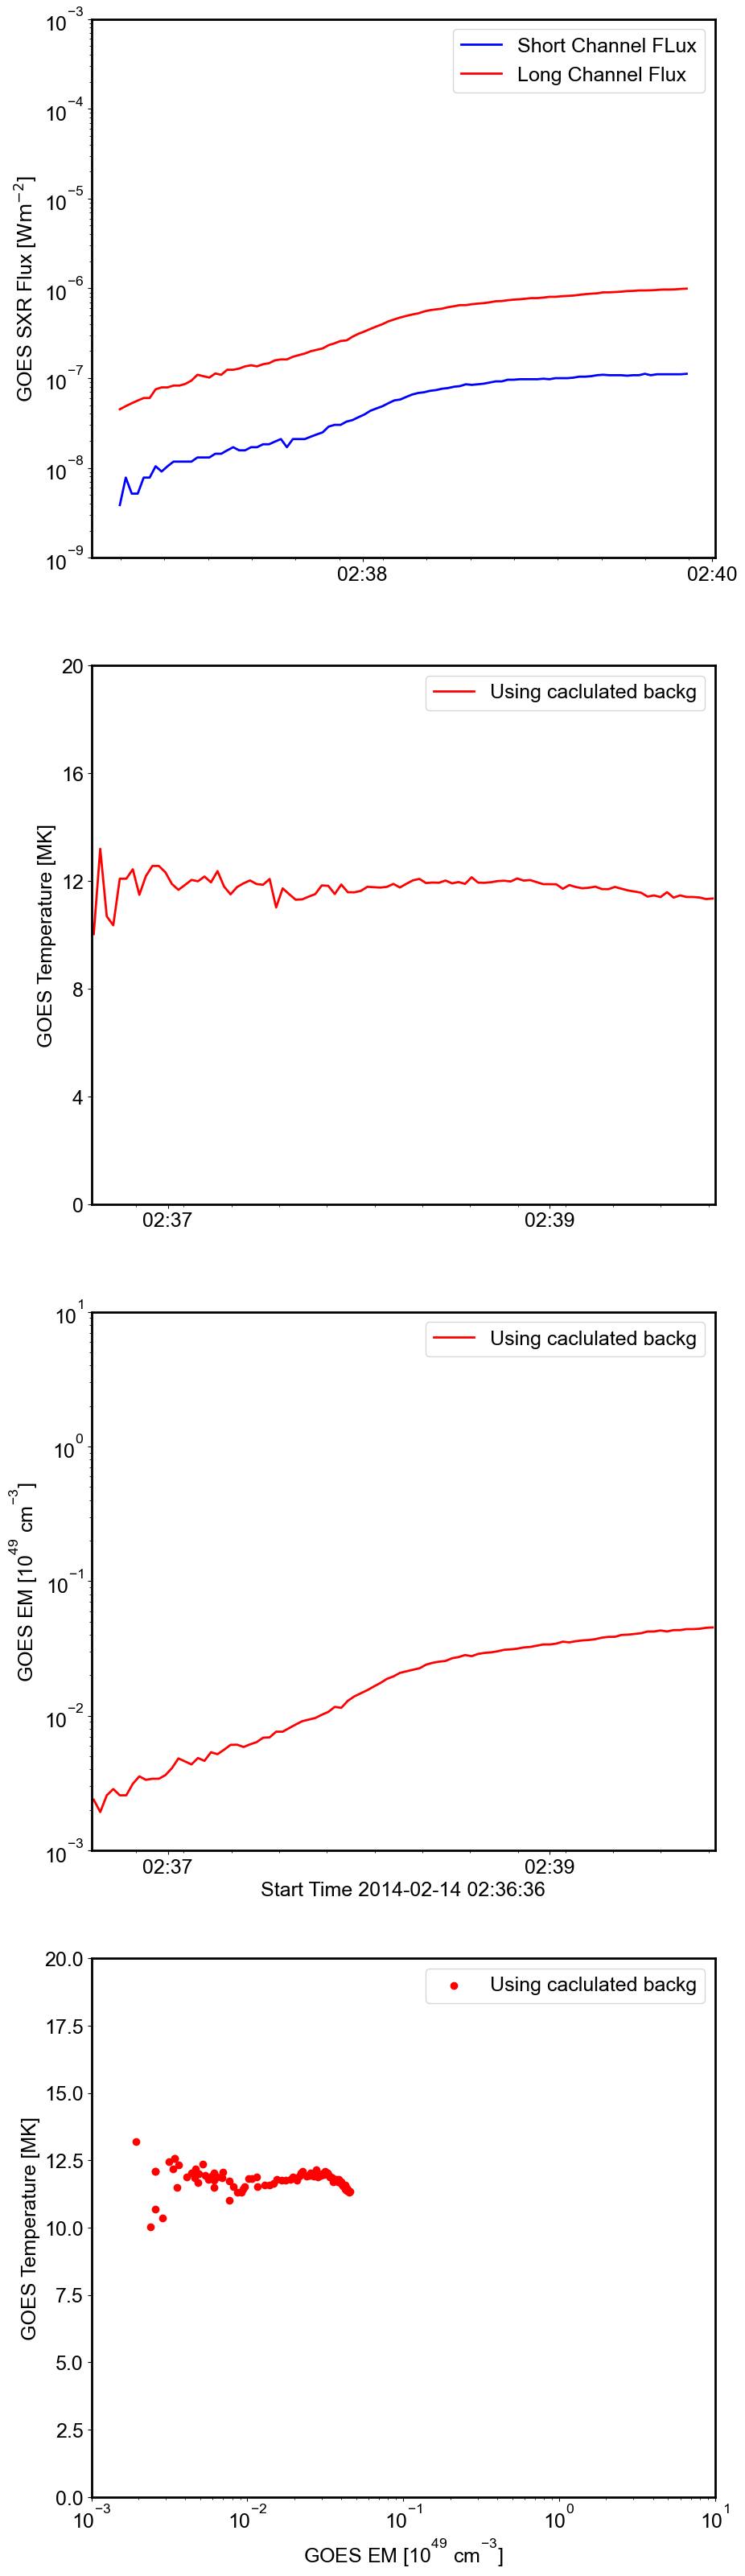

In [9]:
fig= plt.figure(figsize=(10, 40))

# First plot: non-background subtracted long time-series data
ax0 = fig.add_subplot(4, 1, 1)
plt.plot(g_onset_tims, g_onset_short, marker=None,color='blue',lw=2, label = "Short Channel FLux")
plt.plot(g_onset_tims, g_onset_long, marker=None,color='red',lw=2, label = 'Long Channel Flux')
ax0.set_ylabel("GOES SXR Flux [$\mathrm{Wm^{-2}}$]")
ax0.set_ylim([10**(-9), 10**(-3)])
#ax0.yaxis.set_major_locator(plt.MaxNLocator(10))
ax0.set_yscale("log")
ax0.set_xlabel(" ")
#ax0.set_xlim([trange.start.datetime,trange.end.datetime])
#ax0.set_xlim([(a.Time('11:30:00', '17:00')).start.datetime,trange.end.datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=2)
minorx= matplotlib.dates.SecondLocator(interval=15)
ax0.xaxis.set_major_locator(majorx)
ax0.xaxis.set_minor_locator(minorx)
ax0.xaxis.set_major_formatter(myFmt)
#ax0.axvspan(backg_trange.start.datetime,backg_trange.end.datetime,color='grey',alpha=0.4, label='Background')
plt.legend()

# Second plot: background subtracted fluxes to calculate Temperature over short timescale
ax1 = fig.add_subplot(4, 1, 2)
plt.plot(g_onset_tims, tmk,marker=None,color='red',lw=2, label = "Using caclulated backg")
ax1.set_ylabel("GOES Temperature [MK]")
ax1.set_xlabel(" ")
ax1.set_ylim([0,20])
ax1.yaxis.set_major_locator(plt.MaxNLocator(5))
ax1.set_xlim([trange_onset.start.datetime,trange_onset.end.datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=2)
minorx= matplotlib.dates.SecondLocator(interval=15)
ax1.xaxis.set_major_locator(majorx)
ax1.xaxis.set_minor_locator(minorx)
ax1.xaxis.set_major_formatter(myFmt)
plt.legend()

ax2 = fig.add_subplot(4, 1, 3)
plt.plot(g_onset_tims,em*1e-49,marker=None,color='red',lw=2, label = "Using caclulated backg") # Current visualisation using my background
ax2.set_ylabel("GOES EM [$10^{49}\;cm^{-3}$]")
ax2.set_xlabel("Start Time "+trange_onset.start.iso[:-4])
ax2.set_ylim([1e-3,1e1])
ax2.set_yscale("log")
ax2.set_xlim([trange_onset.start.datetime,trange_onset.end.datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=2)
minorx= matplotlib.dates.SecondLocator(interval=15)
ax2.xaxis.set_major_locator(majorx)
ax2.xaxis.set_minor_locator(minorx)
ax2.xaxis.set_major_formatter(myFmt)
plt.legend()

ax3 = fig.add_subplot(4, 1, 4)
plt.scatter(em*1e-49,tmk,marker=None,color='red', label = "Using caclulated backg")
ax3.set_xlabel("GOES EM [$10^{49}\;cm^{-3}$]")
ax3.set_ylabel("GOES Temperature [MK]")
ax3.set_xlim([1e-3,1e1])
ax3.set_ylim([0,20])
ax3.set_xscale("log")
plt.legend()


plt.show()